# 初始化

In [0]:
#@markdown - **挂载** 
from google.colab import drive
drive.mount('GoogleDrive')

In [0]:
# #@markdown - **卸载**
# !fusermount -u GoogleDrive

# 代码区

In [0]:
#@title 混合高斯模型 { display-mode: "both" }
# 该程序实现EM算法对混合高斯模型参数的估计
# 混合高斯模型对随机数据的聚类
# coding: utf-8
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [0]:
#@markdown - **绑定数据**
class Bunch(dict):  
    def __init__(self,*args,**kwds):  
        super(Bunch,self).__init__(*args,**kwds)  
        self.__dict__ = self

In [0]:
#@markdown - **混合高斯模型类**
class GaussianMM: 
    def __init__(self):
        self.mu = None
        self.sigma = None
        self.alpha = None
        self.f_dim = None
        self.num_mixed = None

    # 初始化
    def init_fn(self, f_dim=3, num_mixed=4):
        self.f_dim = f_dim
        self.num_mixed = num_mixed
        self.mu = np.random.randn(num_mixed, f_dim) + 10
        self.sigma = np.zeros((num_mixed, f_dim, f_dim))
        for i in range(num_mixed):
            self.sigma[i, :, :] = np.diag(np.random.randint(10, 25, size=(3, )))
        self.alpha = [1. / num_mixed] * int(num_mixed)
        return 'Initialization completed !'

    # e-step
    def e_step(self, X):
        N, _ = X.shape
        expec = np.zeros((N, self.num_mixed))
        for i in range(N):  
            denom = 0  
            # numer = 0
            F_list = []
            S_list = []
            for j in range(self.num_mixed):
                sig_inv = np.linalg.inv(self.sigma[j, :, :])
                expo_1 = np.matmul(-(X[i, :] - self.mu[j, :]), sig_inv)
                expo_2 = np.matmul(expo_1, ((X[i, :] - self.mu[j, :])).reshape(-1, 1))
                first_half = self.alpha[j] * np.exp(expo_2)
                # first_half = alpha_[j] * np.exp(-(X[i, :] - mu[j, :]) * sig_inv * ((X[i, :] - mu[j, :])).reshape(-1, 1))
                sec_half = np.sqrt(np.linalg.det(np.mat(self.sigma[j, :, :])))
                F_list.append(first_half[0])
                S_list.append(sec_half)
                denom += first_half[0] / sec_half      #分母
            for j in range(self.num_mixed):  
                numer = F_list[j] / S_list[j]        #分子
                expec[i, j]= numer / denom      #求期望
        return expec

    # m-step
    def m_step(self, X, expec):  
        N, c = X.shape
        lemda = 1e-15
        for j in range(self.num_mixed):  
            denom = 0   #分母  
            numer = 0   #分子 
            sig = 0 
            for i in range(N):  
                numer += expec[i, j] * X[i, :]  
                denom += expec[i, j]
            self.mu[j, :] = numer / denom    #求均值  
            for i in range(N):
                x_tran = (X[i, :] - self.mu[j, :]).reshape(-1, 1)
                x_nor = (X[i, :] - self.mu[j, :]).reshape(1, -1)
                sig += expec[i, j] * np.matmul(x_tran, x_nor)
            self.alpha[j] = denom / N        #求混合项系数
            self.sigma[j, :, :] = sig / denom + np.diag(np.array([lemda] * c))
        return self.mu, self.sigma, self.alpha

    # 训练
    def fit(self, X, err_mu=5, err_alpha=0.01, max_iter=100):
        iter_num = 0
        while True:
            if iter_num == max_iter: break
            iter_num += 1
            mu_prev = self.mu.copy()
            # print(mu_prev)
            alpha_prev = self.alpha.copy()
            # print(alpha_prev)
            expec = self.e_step(X)
            self.mu, self.sigma, self.alpha = self.m_step(X, expec)
            print(u"迭代次数:", iter_num)
            print(u"估计的均值:\n", self.mu)
            print(u"估计的混合项系数:", self.alpha, '\n')
            err = abs(mu_prev - self.mu).sum()      #计算误差
            err_a = abs(np.array(alpha_prev) - np.array(self.alpha)).sum()
            if (err < err_mu) and (err_a < err_alpha):     #达到精度退出迭代
                print(u"\n最终误差:", [err, err_a])  
                break
        print('训练已完成 !')
    
    # 预测属于第几个高斯成分
    def predict(self, X):
        expec = self.e_step(X)
        return np.argmax(expec, axis=1)


In [0]:
#@markdown - **生成随机数据函数**
def generate_random(sigma, N, mu1=[15., 25., 10], mu2=[30., 40., 30], mu3=[25., 10., 20], mu4=[40., 30., 40]):  
    c = sigma.shape[-1]
    X = np.zeros((N, c))
    target = np.zeros((N,1))
    for i in range(N):  
        if np.random.random(1) < 0.25: 
            X[i, :]  = np.random.multivariate_normal(mu1, sigma[0, :, :], 1)     #用第一个高斯模型生成3维数据  
            target[i] = 0
        elif 0.25 <= np.random.random(1) < 0.5:  
            X[i, :] = np.random.multivariate_normal(mu2, sigma[1, :, :], 1)      #用第二个高斯模型生成3维数据  
            target[i] = 1
        elif 0.5 <= np.random.random(1) < 0.75:  
            X[i, :] = np.random.multivariate_normal(mu3, sigma[2, :, :], 1)      #用第三个高斯模型生成3维数据  
            target[i] = 2
        else:  
            X[i, :] = np.random.multivariate_normal(mu4, sigma[3, :, :], 1)      #用第四个高斯模型生成3维数据  
            target[i] = 3
    return X, target

In [0]:
#@markdown - **生成带标签的随机数据**
k, N = 4, 400
# 初始化方差，生成样本与标签
sigma = np.zeros((k, 3, 3))
for i in range(k):
	sigma[i, :, :] = np.diag(np.random.randint(10, 25, size=(3, )))
sample, target = generate_random(sigma, N)
feature_names = ['x_label', 'y_label', 'z_label'] # 特征数
target_names = ['gaussian1', 'gaussian2', 'gaussian3', 'gaussian4'] # 类别
data = Bunch(sample=sample, feature_names=feature_names, target=target, target_names=target_names)


In [0]:
#@markdown - **迭代训练，直到满足收敛条件**
# 初始化模型参数
model = GaussianMM()
err_mu = 1e-4 #@param {type: "number"}
err_alpha = 1e-4 #@param {type: "number"}
# -------------二类----------------
model.init_fn(f_dim=3, num_mixed=2)
# print('mu:\n', model.mu)
# print('sigma:\n', model.sigma)
# print('alpha:\n', model.alpha)
# 迭代训练，直到满足收敛条件
model.fit(data.sample, err_mu=err_mu, err_alpha=err_alpha, max_iter=100)
# 预测每个样本属于哪个成分
tar2 = model.predict(data.sample)


迭代次数: 1
估计的均值:
 [[30.12832454 27.71603172 27.77209088]
 [17.17527197 15.41582567 21.56084647]]
估计的混合项系数: [0.9891948357439181, 0.010805164256082694] 

迭代次数: 2
估计的均值:
 [[30.43143103 27.9510174  27.97260947]
 [16.09226436 16.04477222 19.31110429]]
估计的混合项系数: [0.9691009695972226, 0.03089903040277719] 

迭代次数: 3
估计的均值:
 [[30.8445409  28.34067538 28.31037276]
 [16.72280371 15.84568503 18.32500462]]
估计的混合项系数: [0.9393717492826942, 0.06062825071730607] 

迭代次数: 4
估计的均值:
 [[31.19595566 28.81791393 28.6584747 ]
 [17.74506571 15.06408733 18.03783581]]
估计的混合项系数: [0.9102222243488004, 0.08977777565119988] 

迭代次数: 5
估计的均值:
 [[31.48787179 29.2056804  28.9930185 ]
 [18.2419235  14.87278931 17.61506225]]
估计的混合项系数: [0.8867950351112718, 0.11320496488872825] 

迭代次数: 6
估计的均值:
 [[31.81517168 29.65276001 29.42192941]
 [18.67416606 14.76499545 17.07115758]]
估计的混合项系数: [0.8609842309656736, 0.13901576903432622] 

迭代次数: 7
估计的均值:
 [[32.20619647 30.22074926 29.99167762]
 [19.15746394 14.70215087 16.53775374]]
估计的混合项系数: 

In [0]:
# -------------三类----------------
model.init_fn(f_dim=3, num_mixed=3)
model.fit(data.sample, err_mu=err_mu, err_alpha=err_alpha, max_iter=100)
tar3 = model.predict(data.sample)

迭代次数: 1
估计的均值:
 [[29.07033146 30.79352552 32.78270464]
 [17.00961648 15.06713032 16.82136561]
 [30.59030362 26.0129361  25.13916981]]
估计的混合项系数: [0.3422341662697437, 0.006019764070810936, 0.6517460696594454] 

迭代次数: 2
估计的均值:
 [[29.12391046 31.19909997 32.82128511]
 [18.08322946 13.99577784 18.62556534]
 [30.94832472 25.96820556 25.03576444]]
估计的混合项系数: [0.3620109455596802, 0.023280209240756876, 0.6147088451995624] 

迭代次数: 3
估计的均值:
 [[29.34410204 31.34238145 33.15950149]
 [18.25472837 14.90773519 17.56640655]
 [31.23942222 26.20684734 25.1055593 ]]
估计的混合项系数: [0.3633012677560103, 0.043319104762017294, 0.5933796274819724] 

迭代次数: 4
估计的均值:
 [[29.78772573 31.49742465 33.74371403]
 [18.21184493 15.78165002 16.61256531]
 [31.56732589 26.57401474 25.27065847]]
估计的混合项系数: [0.35920050658168656, 0.07036271721661574, 0.5704367762016979] 

迭代次数: 5
估计的均值:
 [[30.57886238 31.75648083 34.74645644]
 [17.73963188 16.84207911 15.5542074 ]
 [31.88875224 26.90959387 25.45770952]]
估计的混合项系数: [0.3505354712159192,

In [0]:
# -------------四类----------------
model.init_fn(f_dim=3, num_mixed=4)
model.fit(data.sample, err_mu=err_mu, err_alpha=err_alpha, max_iter=100)
tar4 = model.predict(data.sample)

迭代次数: 1
估计的均值:
 [[11.31363018 23.23890553  9.50455692]
 [34.57724006 21.75752261 33.42756415]
 [32.34983804 35.35488571 31.11330462]
 [18.15597113 26.8565669  12.21274922]]
估计的混合项系数: [0.00215244434743851, 0.4258864502669146, 0.341945250643189, 0.23001585474245767] 

迭代次数: 2
估计的均值:
 [[11.08650334 23.38907169 12.77887518]
 [34.57737686 21.76163175 33.35528046]
 [33.68311162 36.66349372 32.29730446]
 [16.08327528 25.6993757  10.07353561]]
估计的混合项系数: [0.011581371611807974, 0.4390952928116145, 0.3319511505482241, 0.21737218502835357] 

迭代次数: 3
估计的均值:
 [[11.53246636 23.37784747 11.63027261]
 [34.51900858 21.7840157  33.40285091]
 [33.84772928 36.61737579 32.22257434]
 [15.74380881 25.28939774  9.72684533]]
估计的混合项系数: [0.017865668720702384, 0.4348079724473006, 0.3400472171410777, 0.20727914169091943] 

迭代次数: 4
估计的均值:
 [[11.92320056 23.16406387 10.9963831 ]
 [34.41420692 21.77873301 33.39986848]
 [33.9844156  36.38704461 32.2411776 ]
 [15.78478784 25.35007424  9.74595458]]
估计的混合项系数: [0.022184084

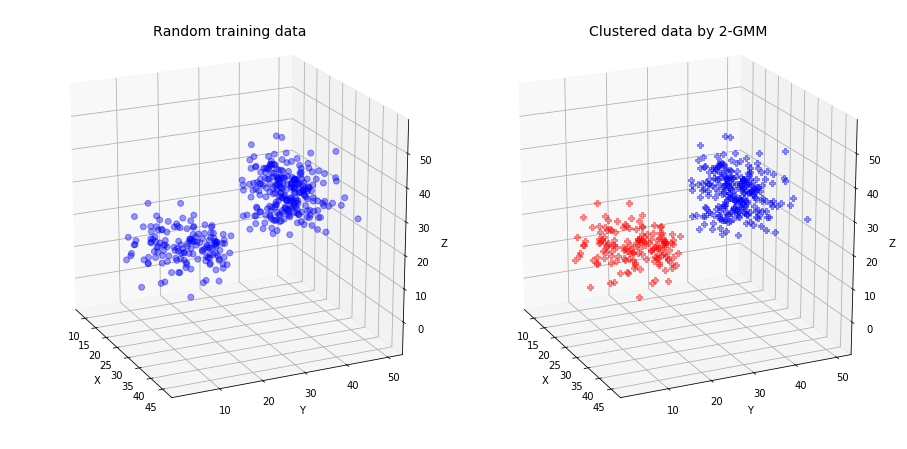

In [0]:
#@markdown - **显示训练数据的分布以及聚类结果**
#@markdown - **训练数据与二类**
titles = ['Random training data', 'Clustered data by 2-GMM']
DATA = [data.sample, data.sample]
color=['b','r','g','y']
fig = plt.figure(1, figsize=(16, 8))
fig.subplots_adjust(wspace=.01, hspace=.02)
for i, title, data_n in zip([1, 2], titles, DATA):
    ax = fig.add_subplot(1, 2, i, projection='3d')
    if title == 'Random training data':
        ax.scatter(data_n[:,0], data_n[:,1], data_n[:,2], c='b', s=35, alpha=0.4, marker='o')
    else:
        for j in range(N):
            ax.scatter(data_n[j, 0], data_n[j, 1], data_n[j, 2], c=color[tar2[j]], s=35, alpha=0.4, marker='P')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev=20., azim=-25)
    ax.set_title(title, fontsize=14)

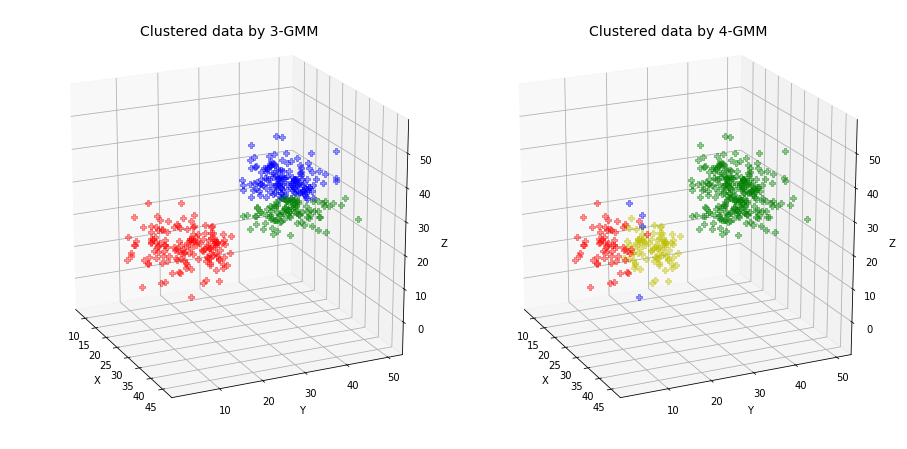

In [0]:
#@markdown - **三类与四类**
titles = ['Clustered data by 3-GMM', 'Clustered data by 4-GMM']
TAR = [tar3, tar4]
fig = plt.figure(2, figsize=(16, 8))
fig.subplots_adjust(wspace=.01, hspace=.02)
for i, title, data_n, tar in zip([1, 2], titles, DATA, TAR):
    ax = fig.add_subplot(1, 2, i, projection='3d')
    for j in range(N):
        ax.scatter(data_n[j, 0], data_n[j, 1], data_n[j, 2], c=color[tar[j]], s=35, alpha=0.4, marker='P')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev=20., azim=-25)
    ax.set_title(title, fontsize=14)
plt.show()